### Tool: Field Ownership Breakdown
#### Given all contest entries, different tools to provide various insight.
##### *Requires: .zip file provided in live/pastcontests tab.*


- Get field ownership, what different *DFS players* did, etc.

In [1]:
import re

import pandas as pd

from collections.abc import Sequence

# Local
import settings.custom

In [12]:
class Field:
    def __init__(
        self,
        namedate: str, # Name of file / date contest was played
        **kwargs
    ):
        """
        Creates field object which has various tools to breakdown DraftKings provided contest file.
        """

        self.raw = pd.read_csv(f'../data/{namedate}.csv')


    @classmethod
    def flatten(cls, nested_seq: Sequence[Sequence[str,...], ...], **kwargs) -> list[str,...]:
        """
        Takes 2d sequence and returns all values in 1d
        Example: [(a,b,c), (a,y,z), (a,b,z)] -> [a, b, c, a, y, z, a, b, z]
        TODO: kwargs to add functinoality
            - unique: [(a,b,c), (a,y,z), (a,b,z)] -> [a, b, c, y, z]
            - counts dict -> {a: 3, b: 2, z: 2, c: 1, z: 1} (recursive)
            - etc
        """
        if kwargs.get('unique', False):
            return list(set(cls.flatten(nested_seq)))

        return [element for innerSeq in nested_seq for element in innerSeq]

    @staticmethod
    def convert_str_to_tuple(lineup_str: str) -> tuple[str,str,str,str,str,str,str,str]:
        """
        Converts string of names with no commas or anything into a tuple of those names,
        used in conjunction with following function.
        """
        parts = lineup_str.split(' ')
        
        # if len(parts) != 16: # lineup_str.count(' ') == 15 is same thing
        #     # abnormal lineup
        #     return tuple(['issue', 'with', 'lineup'])
    
        return tuple([' '.join([parts[n], parts[n+1]]) for n in [n_ for n_ in range(15) if n_%2 == 0]])

    @classmethod
    def convert_to_lineup(cls, lineup_str: str) -> str:
        """
        Removes the positions (ex: 'PG', 'F') from the provided string and then creates lineup with all positions removed.
        """
        # if isinstance(lineup_str, float):
        #     return lineup_str

        if 'LOCKED' not in lineup_str:
            for pos in ['PG', 'SG', 'SF', 'PF', 'C', 'G', 'F', 'UTIL']:
                
                # Know first character always to be replaced
                if lineup_str.index(pos) == 0:
                    lineup_str = lineup_str.replace(pos, '', 1)
                else:
                    lineup_str = re.sub(fr' {pos} ', ' ', lineup_str)
            
            # Remove space before not space after since position comes before name
            for name_part in ('Jr.', 'Jr', 'III', 'IV'):
                lineup_str = lineup_str.replace(f' {name_part}', '')
                
            return cls.convert_str_to_tuple(lineup_str.lstrip())
    
    @classmethod
    def exposures(cls, lineups: tuple[tuple[str,...], ...], **kwargs) -> pd.Series:
        """
        Returns the exposure of players in multiple lineups
        """
        
        n_lineups = len(lineups)
        flattened = cls.flatten(lineups)
        
        # Raw numbers
        # counts = {name_: flattened.count(name_) for name_ in set(flattened)}
        
        # Exposures as percentages
        exposure = {name_: 100 * flattened.count(name_) / n_lineups for name_ in set(flattened)}

        contestant = kwargs.get('contestant')

        title = 'Exposures'
        if contestant is not None:
            title += f" for {contestant}'s {n_lineups} entries:"
        
        return (pd
                .Series(exposure)
                .sort_values()
                .plot
                .barh(
                    figsize=(60,40),
                    title=title
                )
               )
    
    def clean_data(self, **kwargs) -> None:
        """
        Cleans the raw DraftKings provided file into customized format.
        TODO: Documentation when functionality added
        """

        if hasattr(self, 'clean'):
            return
        
        self.performances = (self.raw
                             .copy(deep=True)
                             [['Player', '%Drafted', 'FPTS']]
                             .set_axis(['name', 'own', 'fpts'], axis=1)
                             .dropna()
                             .assign(
                                 own=lambda df_: df_.own.map(lambda ownstr: float(ownstr.replace('%', ''))),
                                 fpts=lambda df_: df_.fpts.astype('float')
                             )
                            )
        
        self.clean = (self.raw
                      .copy(deep=True)
                      [['Rank', 'EntryName', 'Points', 'Lineup']]
                      .set_axis(['rank', 'entry', 'fpts', 'lineup'], axis=1)
                      .dropna()
                      .assign(
                          lineup=lambda df_: df_.lineup.map(lambda lineup_str_: self.convert_to_lineup(lineup_str_)),
                          # Remove the brackets showing which entry of persons
                          entry=lambda df_: df_.entry.map(lambda entry_str: entry_str.split(' ')[0]),
                          # Ordered lineup, no longer ordered by position
                          ordered=lambda df_: df_.lineup.map(lambda lineup_: tuple(sorted(lineup_)))
                      )
                     )

        

        return

    def dupes(self, **kwargs):
        """
        Returns all lineups that were duped
        """
        if not hasattr(self, 'clean'):
            self.clean_data()

        dupes = (self.clean
                 .groupby('ordered')
                 ['lineup']
                 .agg(['count'])
                 .pipe(lambda df_: df_.loc[df_['count'] > 1])
                 .sort_values('count', ascending=False)
                )

        return dupes
    
    def contestant_ownership(self, contestant: str, **kwargs):
        """
        Returns the ownership another contestant had
        """
        
        
        if not hasattr(self, 'clean'):
            self.clean_data()

        if contestant not in list(self.clean['entry'].drop_duplicates()):
            return pd.Series(data={'Missing': 'Entrant'})
        
        df = (self.clean
              .pipe(lambda df_: df_.loc[df_['entry'] == contestant])
             )
        
        return self.exposures(tuple(df['lineup']), contestant=contestant)
        
        
    def ownership(self, **kwargs):
        """
        Returns ownership breakdown for that slate, with keyword option for return type.
        """

        if not hasattr(self, 'clean'):
            self.clean_data()
        
        result = kwargs.get('result', 'bar')

        if result in ('dataframe', 'df'):

            return (self.performances
                    [['name', 'own']]
                    .sort_values('own', ascending=False)
                   )

        if result in ('series', 's'):

            return (self.performances
                    [['name', 'own']]
                    .sort_values('own', ascending=False)
                    .set_index('name')
                   )


        return (self.performances
                [['name', 'own']]
                .pipe(lambda df_: df_.loc[df_['own'] >= 2.0])
                .sort_values('own', ascending=True)
                .set_index('name')
                .plot
                .barh(
                    figsize=(60,40),
                    title='Ownership Distribution for Contest'
                )
               )
            
        

In [13]:
# Warning may appear for large files, no problems with data -> pandas just causes the warning since it reads in chunks
field = Field('2024-03-19-main')
# field.clean_data()

In [14]:
# (field.clean
#  .pipe(lambda df_: df_.loc[df_['entry'] == 'jdeegs99'])
# )

In [15]:
# (field.clean
#  .groupby('entry')
#  ['fpts']
#  .agg(['mean', 'count'])
#  .sort_values('mean', ascending=False)
#  .pipe(lambda df_: df_.loc[df_['count'] == 20])
#  .head(10)
# )

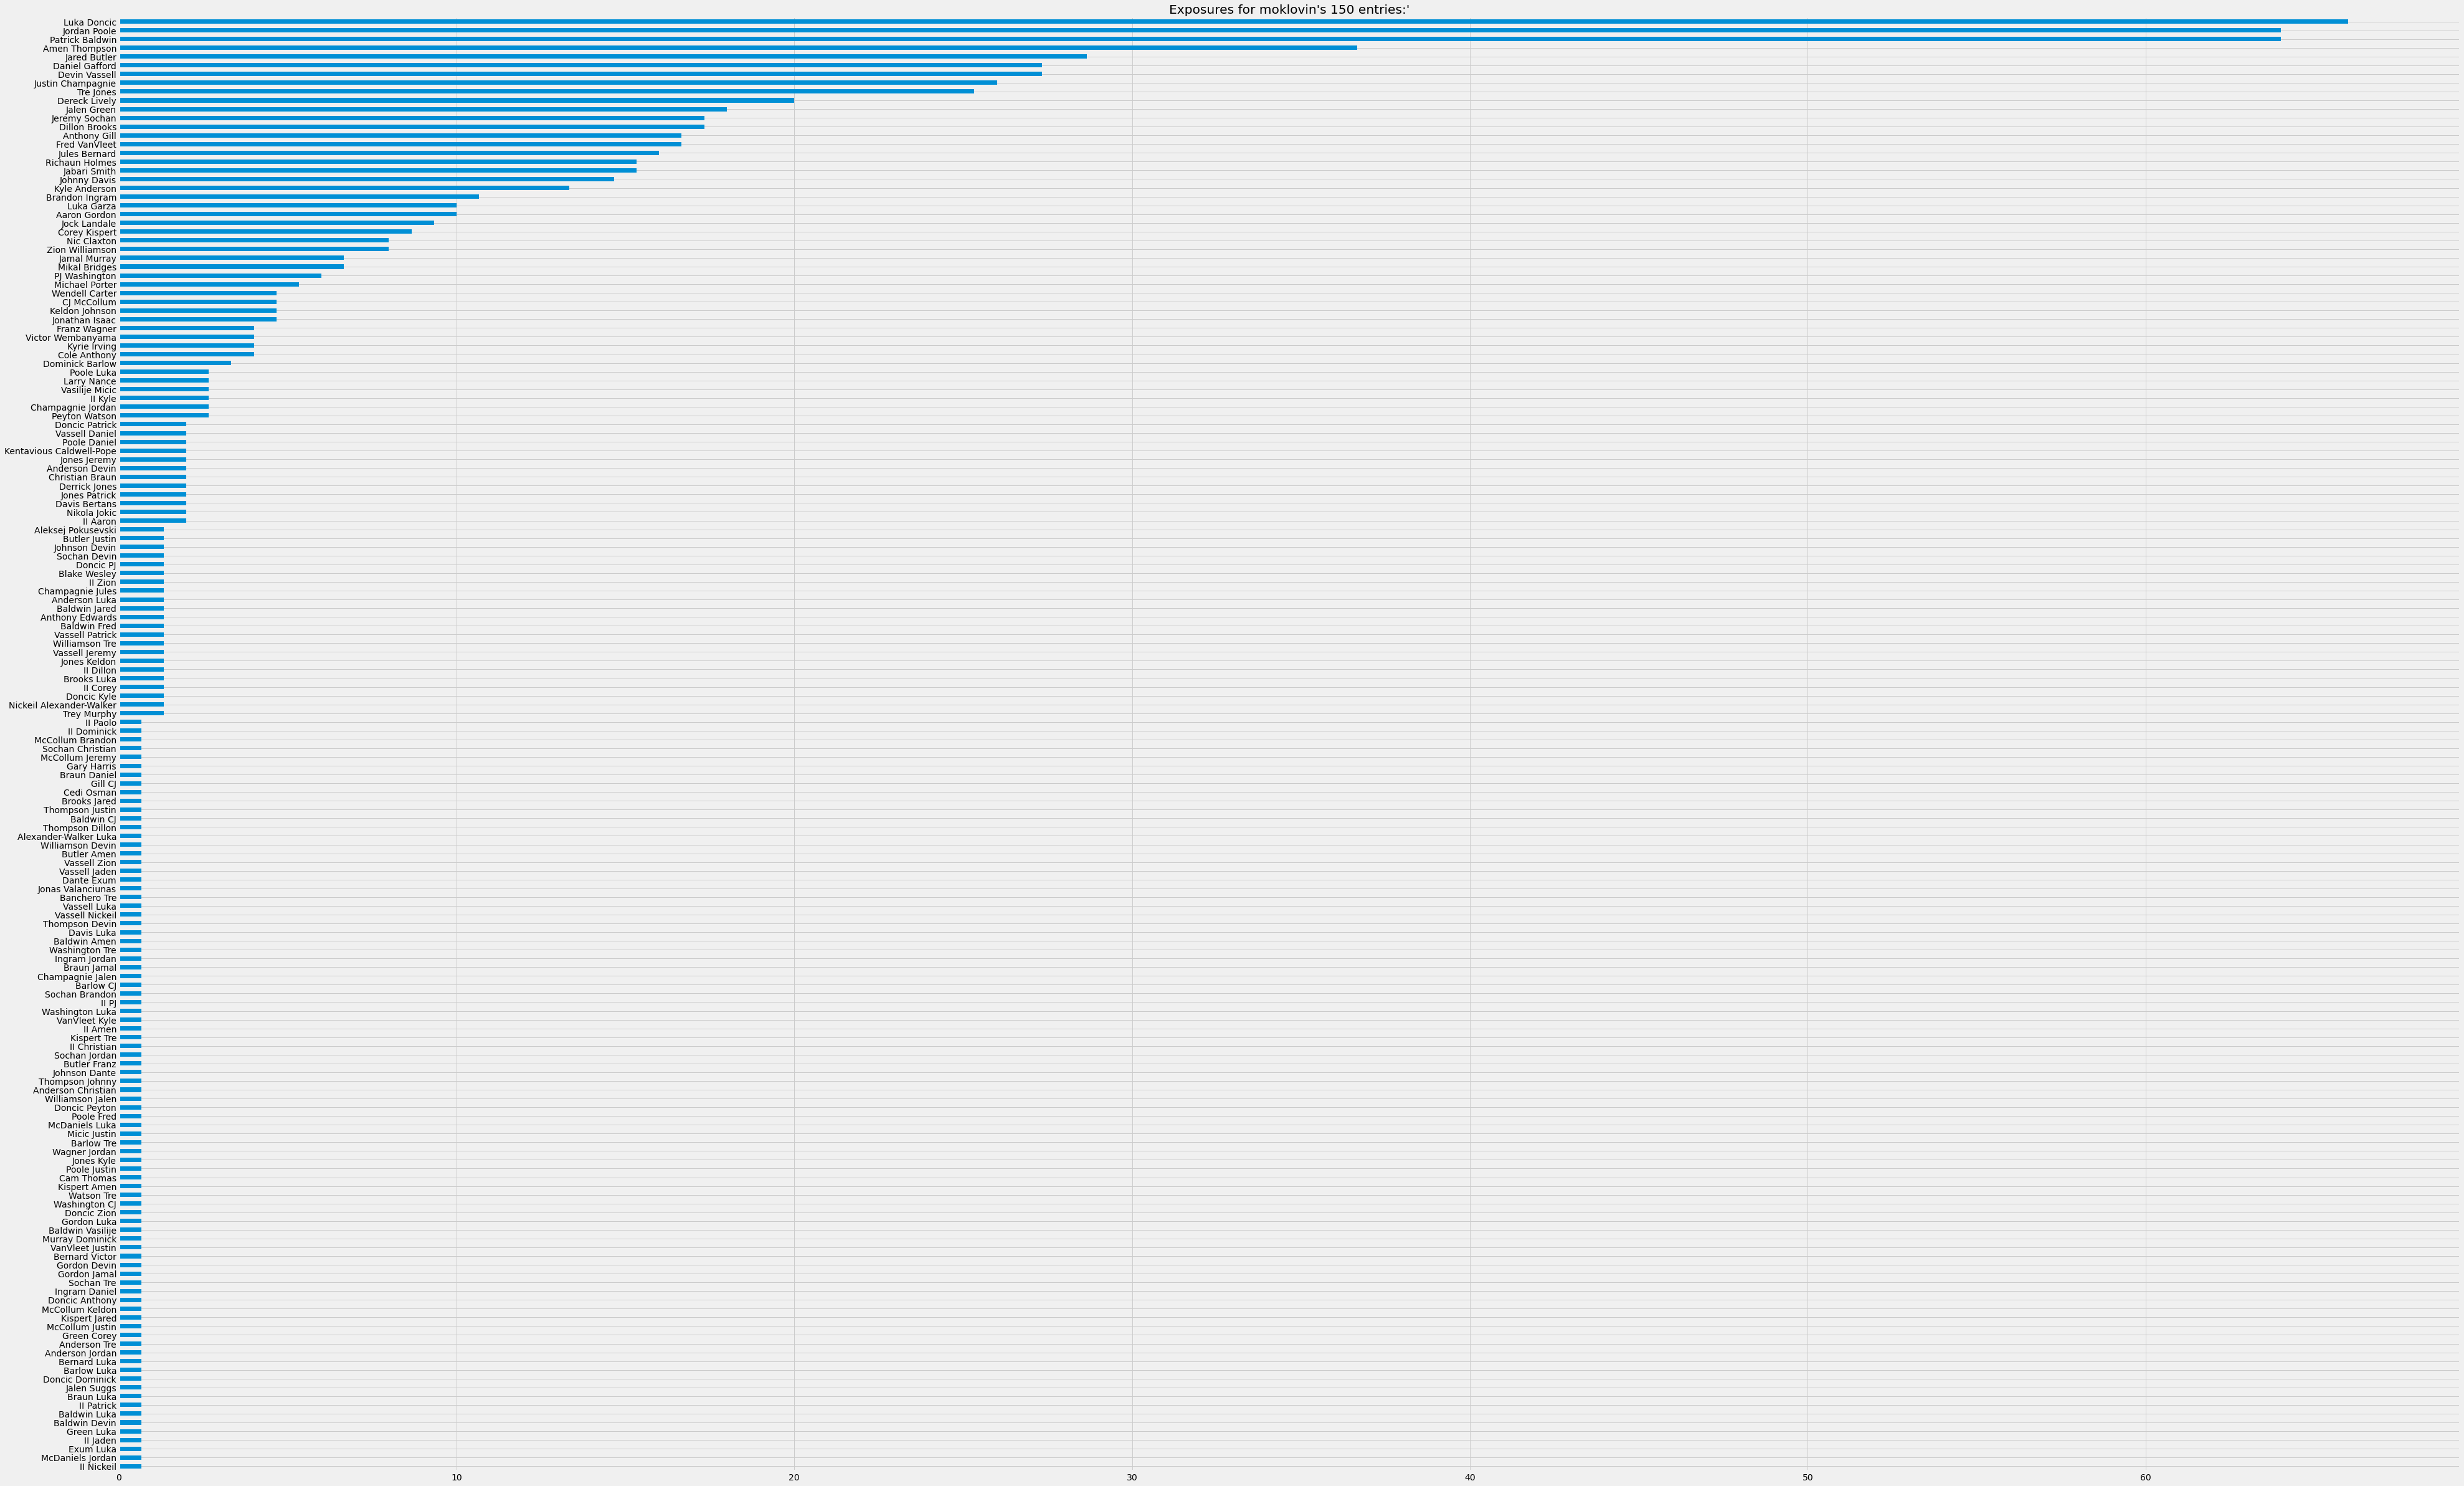

In [16]:
field.contestant_ownership('moklovin');

In [26]:
field.dupes()

,count
ordered,
"(Jared Butler, Jayson Tatum, Jordan Poole, Justin Champagnie, Kawhi Leonard, Oshae Brissett, Sam Hauser, Victor Wembanyama)",128
"(Cam Thomas, Jayson Tatum, Jordan Poole, Jrue Holiday, Justin Champagnie, Oshae Brissett, Patrick Baldwin, Victor Wembanyama)",98
"(Jayson Tatum, Jrue Holiday, Justin Champagnie, Kawhi Leonard, Oshae Brissett, Patrick Baldwin, Sam Hauser, Victor Wembanyama)",65
"(Dejounte Murray, Jared Butler, Jayson Tatum, Jordan Poole, Justin Champagnie, Oshae Brissett, Patrick Baldwin, Victor Wembanyama)",63
"(Jared Butler, Jayson Tatum, Jordan Poole, Justin Champagnie, Kawhi Leonard, Oshae Brissett, Richaun Holmes, Victor Wembanyama)",51
...,...
"(Clint Capela, Dorian Finney-Smith, Jalen Suggs, Kawhi Leonard, Nic Claxton, Paul George, Payton Pritchard, Sam Hauser)",2
"(Clint Capela, Eugene Omoruyi, Jared Butler, Jayson Tatum, Jordan Poole, Justin Champagnie, Kawhi Leonard, Paul George)",2
"(Clint Capela, Eugene Omoruyi, Jayson Tatum, Jordan Poole, Jrue Holiday, Justin Champagnie, Patrick Baldwin, Victor Wembanyama)",2


In [94]:
field.clean.iloc[0]['lineup']

('Victor Wembanyama',
 'Sam Hauser',
 'Jordan Poole',
 'Moritz Wagner',
 'Payton Pritchard',
 'Jayson Tatum',
 'Justin Champagnie',
 'Jalen Johnson')

In [89]:
teststr = 'Victor Wembanyama Sam Hauser Jordan Poole Moritz Wagner Payton Pritchard Jayson Tatum Justin Champagnie Jalen Johnson'

In [90]:
convert_to_lineup(teststr)

('Victor Wembanyama',
 'Sam Hauser',
 'Jordan Poole',
 'Moritz Wagner',
 'Payton Pritchard',
 'Jayson Tatum',
 'Justin Champagnie',
 'Jalen Johnson')